In [1]:
!pip install tensorflow keras

# подключение библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

In [2]:
import pandas as pd

data = pd.read_csv('../../data/titanic_train.csv', index_col='PassengerId').drop(['Ticket', 'Cabin', 'Name'], axis='columns')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 891


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [6]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        

class GetArray(BaseEstimator):
    def fit(self, X : pd.DataFrame = None, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
        
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()
class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
      
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

In [9]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(data.drop('Pclass', axis=1), columns=['Sex', 'Embarked'])

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data['Pclass']

fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(751, 10) (751, 3)


/srv/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[0.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.75770122, 0.        , 0.        , 0.31457232,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.1277244 , 1.        , 0.5       , 0.12783054,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.4305

In [13]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((751, 10), (751, 3))

In [14]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [16]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1])) # input_dim = 4
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3

model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

In [18]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=4)

Epoch 1/100
 - 0s - loss: 0.4683 - categorical_accuracy: 0.8455
Epoch 2/100
 - 0s - loss: 0.4665 - categorical_accuracy: 0.8429
Epoch 3/100
 - 0s - loss: 0.4677 - categorical_accuracy: 0.8415
Epoch 4/100
 - 0s - loss: 0.4672 - categorical_accuracy: 0.8509
Epoch 5/100
 - 0s - loss: 0.4683 - categorical_accuracy: 0.8415
Epoch 6/100
 - 0s - loss: 0.4648 - categorical_accuracy: 0.8455
Epoch 7/100
 - 0s - loss: 0.4674 - categorical_accuracy: 0.8455
Epoch 8/100
 - 0s - loss: 0.4662 - categorical_accuracy: 0.8375
Epoch 9/100
 - 0s - loss: 0.4650 - categorical_accuracy: 0.8469
Epoch 10/100
 - 0s - loss: 0.4653 - categorical_accuracy: 0.8455
Epoch 11/100
 - 0s - loss: 0.4653 - categorical_accuracy: 0.8415
Epoch 12/100
 - 0s - loss: 0.4656 - categorical_accuracy: 0.8469
Epoch 13/100
 - 0s - loss: 0.4653 - categorical_accuracy: 0.8482
Epoch 14/100
 - 0s - loss: 0.4634 - categorical_accuracy: 0.8442
Epoch 15/100
 - 0s - loss: 0.4636 - categorical_accuracy: 0.8442
Epoch 16/100
 - 0s - loss: 0.4627 

In [20]:
model.evaluate(X_train, Y_train)

751/751 [==============================] - 0s 68us/step


[0.44080540764030224, 0.8575233024223825]

In [22]:
from keras import callbacks

# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 751
Тренировочных данных: 601
Тестовых данных: 150
Размер данные для тренировки (входных): (601, 10)
Размер данные для тренировки (выходных): (601, 3)
Размер данные для теста (входных): (150, 10)
Размер данные для теста (выходных): (150, 3)


In [23]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [25]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 1s 1ms/step - loss: 1.1018 - categorical_accuracy: 0.3544 - val_loss: 1.0560 - val_categorical_accuracy: 0.5133
Epoch 2/100
601/601 [==============================] - 0s 813us/step - loss: 1.0294 - categorical_accuracy: 0.5441 - val_loss: 1.0151 - val_categorical_accuracy: 0.5267
Epoch 3/100
601/601 [==============================] - 0s 710us/step - loss: 0.9892 - categorical_accuracy: 0.5424 - val_loss: 0.9877 - val_categorical_accuracy: 0.5467
Epoch 4/100
601/601 [==============================] - 0s 802us/step - loss: 0.9561 - categorical_accuracy: 0.5641 - val_loss: 0.9558 - val_categorical_accuracy: 0.5600
Epoch 5/100
601/601 [==============================] - 1s 862us/step - loss: 0.9262 - categorical_accuracy: 0.5890 - val_loss: 0.9299 - val_categorical_accuracy: 0.5600
Epoch 6/100
601/601 [==============================] - 0s 829us/step - loss: 0.8992 - ca

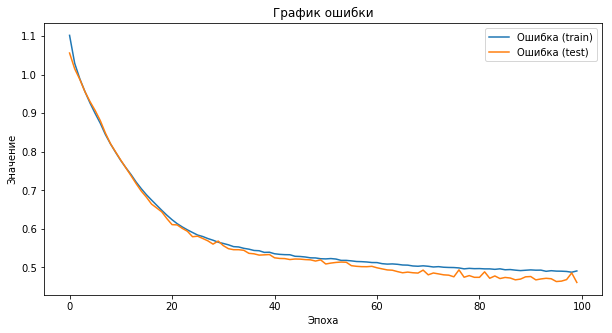

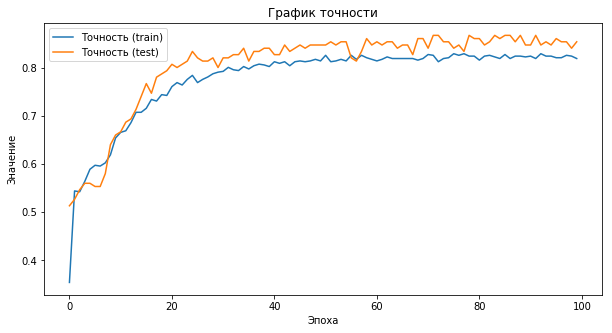

In [27]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [28]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 1s 2ms/step - loss: 1.1039 - categorical_accuracy: 0.3567 - val_loss: 1.0617 - val_categorical_accuracy: 0.5298
Epoch 2/100
600/600 [==============================] - 1s 1ms/step - loss: 1.0288 - categorical_accuracy: 0.5117 - val_loss: 1.0306 - val_categorical_accuracy: 0.5298
Epoch 3/100
600/600 [==============================] - 1s 977us/step - loss: 0.9971 - categorical_accuracy: 0.5383 - val_loss: 1.0025 - val_categorical_accuracy: 0.5497
Epoch 4/100
600/600 [==============================] - 1s 983us/step - loss: 0.9581 - categorical_accuracy: 0.5700 - val_loss: 0.9740 - val_categorical_accuracy: 0.5497
Epoch 5/100
600/600 [==============================] - 1s 984us/step - loss: 0.9178 - categorical_accuracy: 0.6133 - val_loss: 0.9493 - val_categorical_accuracy: 0.5695
Epoch 6/100
600/600 [==============================] - 1s 960us/step - loss: 0.8756 - cate

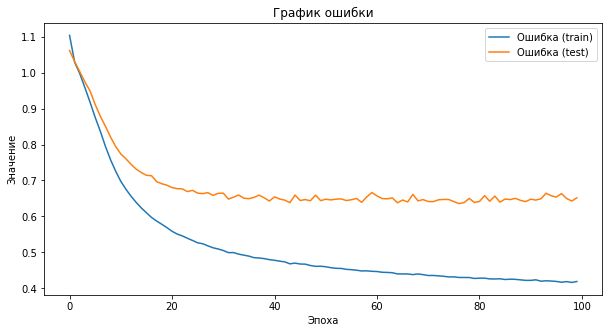

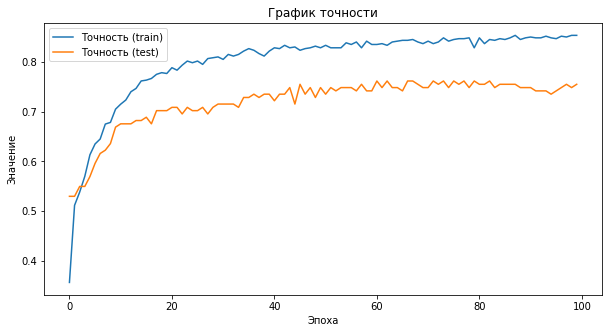

In [30]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [31]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 1s 2ms/step - loss: 1.0981 - categorical_accuracy: 0.3383 - val_loss: 1.0107 - val_categorical_accuracy: 0.5166
Epoch 2/300
600/600 [==============================] - 1s 1ms/step - loss: 0.9747 - categorical_accuracy: 0.5500 - val_loss: 0.9383 - val_categorical_accuracy: 0.5894
Epoch 3/300
600/600 [==============================] - 1s 1ms/step - loss: 0.9184 - categorical_accuracy: 0.5867 - val_loss: 0.9079 - val_categorical_accuracy: 0.6026
Epoch 4/300
600/600 [==============================] - 1s 893us/step - loss: 0.8811 - categorical_accuracy: 0.6183 - val_loss: 0.8849 - val_categorical_accuracy: 0.6159
Epoch 5/300
600/600 [==============================] - 1s 862us/step - loss: 0.8495 - categorical_accuracy: 0.6317 - val_loss: 0.8634 - val_categorical_accuracy: 0.6291
Epoch 6/300
600/600 [==============================] - 1s 933us/step - loss: 0.8202 - catego

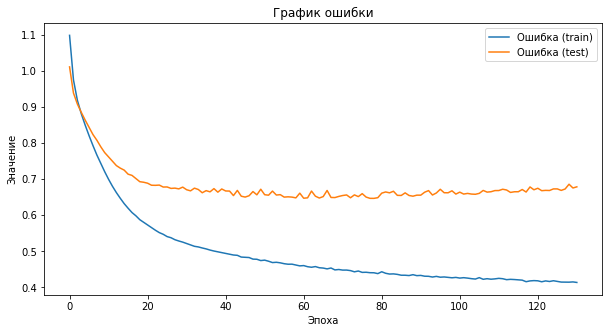

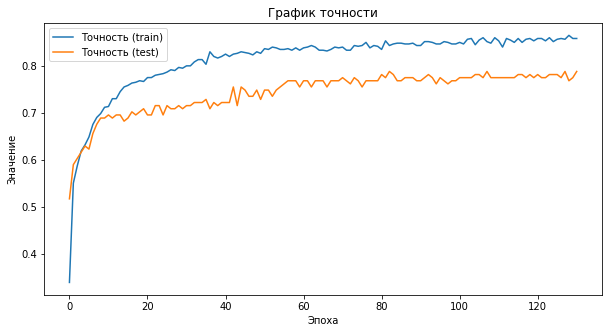

In [34]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [37]:

from pathlib import Path
from os import remove

# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [38]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками /home/jovyan/лабы_решения/1562_2/save_points
Train on 480 samples, validate on 121 samples
Epoch 1/300
480/480 [==============================] - 1s 2ms/step - loss: 1.0532 - categorical_accuracy: 0.5063 - val_loss: 0.9975 - val_categorical_accuracy: 0.5537
Epoch 2/300
480/480 [==============================] - 0s 800us/step - loss: 0.9939 - categorical_accuracy: 0.5792 - val_loss: 0.9515 - val_categorical_accuracy: 0.6033
Epoch 3/300
480/480 [==============================] - 0s 1ms/step - loss: 0.9476 - categorical_accuracy: 0.6000 - val_loss: 0.9090 - val_categorical_accuracy: 0.5868
Epoch 4/300
480/480 [==============================] - 0s 876us/step - loss: 0.9056 - categorical_accuracy: 0.6146 - val_loss: 0.8716 - val_categorical_accuracy: 0.6364
Epoch 5/300
480/480 [==============================] - 1s 1ms/step - loss: 0.8726 - categorical_accuracy: 0.6292 - val_loss: 0.8486 - val_categorical_accuracy: 0.6364
Epoch 6/

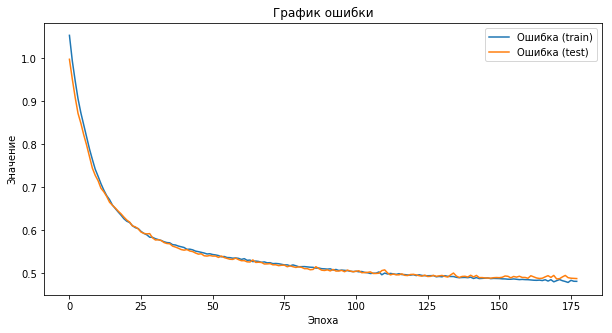

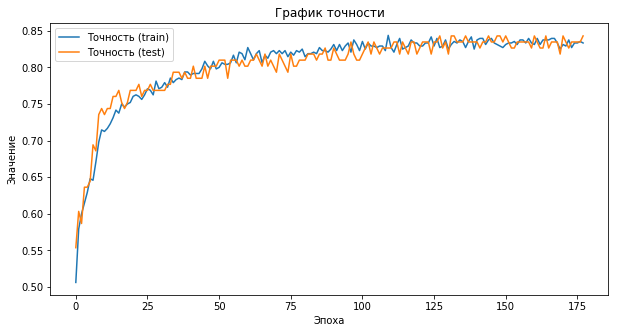

In [40]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [46]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.49_val_loss-0.49_acc-0.84_val_acc-0.84.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

601/601 [==============================] - 0s 299us/step
Точность предсказания на тренировочных данных 0.8452579024032427
150/150 [==============================] - 0s 108us/step
Точность предсказания на тестовых данных 0.8599999968210856


array([2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 1, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 1, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 1])

In [48]:
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

array([3, 2, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 2, 3, 3, 2, 1, 1, 2, 3, 2, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 1, 3,
       3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3,
       1, 3, 3, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2, 1, 3, 3, 2, 1, 2, 1, 2,
       3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 2, 1, 3, 3, 1, 3, 2, 3, 2, 3, 3,
       3, 1, 3, 3, 3, 3, 2, 2, 2, 3, 3, 1, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 1, 1, 2])

In [50]:
loaded_model.predict(X_train)

array([[4.69624810e-03, 3.97657663e-01, 5.97646058e-01],
       [9.55898594e-03, 1.69466808e-01, 8.20974231e-01],
       [7.41680622e-01, 2.57524461e-01, 7.94938416e-04],
       ...,
       [9.71515715e-01, 2.81838253e-02, 3.00441723e-04],
       [4.01724083e-03, 1.09203465e-01, 8.86779249e-01],
       [3.08194081e-03, 4.07971948e-01, 5.88946104e-01]], dtype=float32)